In [179]:
import pandas as pd
import numpy as np
import re
import json
from pathlib import Path

import matplotlib.pyplot as plt

In [180]:
ROOT = Path('/Volumes/INWT/Daten_NLP/') # encrypted folder!
DATA = ROOT / '200707_aachener_zeitung.txt'
META = ROOT / 'Dokumentation_Daten.txt'

## Reading in sample data

In [181]:
raw = pd.read_csv(DATA, encoding='utf-8', error_bad_lines=False, quotechar = '"', doublequote=False) # index_col=0

# Achtung: in row 116, 180, 215, 308, 461, 625 treten Fehler auf ???

b'Skipping line 116: expected 52 fields, saw 54\nSkipping line 180: expected 52 fields, saw 53\nSkipping line 215: expected 52 fields, saw 53\nSkipping line 308: expected 52 fields, saw 55\nSkipping line 461: expected 52 fields, saw 55\nSkipping line 625: expected 52 fields, saw 53\n'


In [182]:
import re

## Creating dict with descriptions of columns from meta file

In [183]:
# Zusätzliche Information zu den Spalten 2-11 finden sich unter
# https://ga-dev-tools.appspot.com/dimensions-metrics-explorer/?

meta_dict = {}
with open(META, 'r') as fp:
    line = fp.readline()
    cnt = 1
    while line:
        print(line.strip())
        if '- (' in line:
            line = re.sub(r'- \(\d+\): ', '', line).strip()
            #print(line)
            var_name, var_description = re.split(': | - ',line)
            meta_dict[var_name] = var_description
        line = fp.readline()

Im Folgenden werden die Inhalte der im Datenexport enthaltenen Spalten beschrieben:
- Zusätzliche Information zu den Spalten 2-11 finden sich unter https://ga-dev-tools.appspot.com/dimensions-metrics-explorer/?
- tbi: to be ignored

- (1): articleId - ID (aus CMS des Publishers)
- (2): pageviews - Anzahl Seitenaufrufe
- (3): entrances - Anzahl Einstiege
- (4): exits - Anzahl Ausstiege
- (5): bounces - Anzahl Bounces
- (6): timeOnPage - Verweil- oder Lesedauer in Sekunden (insgesamt)
- (7): conversions - Anzahl Registrierungen/Abos
- (8): avgTimeOnPage - durchschnittliche Verweil- oder Lesedauer in Sekunden
- (9): stickiness - Anteil der Leser, die im Anschluss an den Artikel auf der Publisher-Seite blieben
- (10): entranceRate - Anteil der Leser, die über den Artikel auf die Publisher-Seite kamen
- (11): bounceRate - Anteil der Leser, die Publisher-Seite direkt wieder verlassen haben
- (12): sharePageviews - tbi
- (13): n - tbi
- (14): nObs - tbi
- (15): score_pageviews - tbi
- (16): s

In [184]:
with open('meta_dict.json', 'w') as f:
    json.dump(meta_dict, f)

In [185]:
len(meta_dict)

52

In [186]:
meta_dict['pageviews']

'Anzahl Seitenaufrufe'

In [187]:
for var in meta_dict.keys():
    if meta_dict[var] != 'tbi':
        print(var,':', meta_dict[var])

articleId : ID (aus CMS des Publishers)
pageviews : Anzahl Seitenaufrufe
entrances : Anzahl Einstiege
exits : Anzahl Ausstiege
bounces : Anzahl Bounces
timeOnPage : Verweil- oder Lesedauer in Sekunden (insgesamt)
conversions : Anzahl Registrierungen/Abos
avgTimeOnPage : durchschnittliche Verweil- oder Lesedauer in Sekunden
stickiness : Anteil der Leser, die im Anschluss an den Artikel auf der Publisher-Seite blieben
entranceRate : Anteil der Leser, die über den Artikel auf die Publisher-Seite kamen
bounceRate : Anteil der Leser, die Publisher-Seite direkt wieder verlassen haben
kategorie : Kategorie in der der Publisher den Artikel veröffentlicht hat
rubrik : Unter-Kategorie
subRubrik : UNter-Unter-Kategorie
titel : Titel (Publisher)
pagePath : URL
dpaGuid : ID aus dpa DWH
categoryCode : vm = "Vermischtes"
genre : dto
geoArea : Regioninfo
keywords : Keyword-Liste durch "__,__" getrennt
links : Weiterführende Links zum Artikel, die die dpa bereitstellt
subject : Subject-Liste durch "__,

In [188]:
raw.columns

Index(['articleId', 'pageviews', 'entrances', 'exits', 'bounces', 'timeOnPage',
       'conversions', 'avgTimeOnPage', 'stickiness', 'entranceRate',
       'bounceRate', 'sharePageviews', 'n', 'nObs', 'score_pageviews',
       'score_avgTimeOnPage', 'score_entranceRate', 'score_stickiness',
       'SCORE', 'kategorie', 'rubrik', 'subRubrik', 'titel', 'pagePath',
       'dpaGuid', 'categoryCode', 'creationDate', 'flextags', 'genre',
       'geoArea', 'importance', 'keywords', 'lifetime', 'limbic', 'links',
       'picture', 'service', 'subject', 'subjectBroader', 'subjectCode',
       'teaser', 'text', 'titelH1', 'titelH3', 'urgency', 'wikidata',
       'wordcount', 'category', 'ratgeber', 'format', 'dateLoaded',
       'nLoadAttempts'],
      dtype='object')

In [189]:
raw.shape

(891, 52)

In [190]:
# ignore colums with 'tbi' in meta_dict
use_columns = [var for var in meta_dict.keys() if meta_dict[var] != 'tbi']

In [191]:
len(use_columns)

29

In [192]:
df = raw[use_columns]

In [193]:
df.set_index('articleId', inplace=True)

In [194]:
df.shape

(891, 28)

In [195]:
df.head()

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,...,geoArea,keywords,links,subject,teaser,text,titelH1,titelH3,wordcount,category
articleId,,,,,,,,,,,,,,,,,,,,,
48620281,21,7,12,7,1012,NaN,112.444444,42.857143,33.333333,33.333333,...,Deutschland,"Ratgeber__,__Joggen__,__Laufschuhe__,__Messen_...",NaN,"Gesundheit__,__Sport__,__Medizin__,__Freizeit","Wer ein bisschen durch den Park rennen möchte,...",München/Stuttgart (dpa/tmn) - Frische Luft und...,Ohne Treter läuft nichts: Die richtigen Schuhe...,NaN,769,vm
48620381,19,6,11,5,1484,NaN,185.500000,42.105263,31.578947,26.315789,...,Deutschland,"Ratgeber__,__Psychologie__,__Depressionen__,__...",Info-Telefon Depression,"Gesundheit__,__Medizin","Ewig grauer Himmel, Nässe, Kälte. Je länger de...",Berlin/Frankfurt/Main (dpa/tmn) - Der Wecker k...,Ohne Antrieb: Wann ist der Winter-Blues eine D...,NaN,441,vm
48622639,2,2,2,2,0,NaN,0.000000,0.000000,100.000000,100.000000,...,Deutschland,"Eltern__,__Kinder__,__Ratgeber__,__Baby__,__Ba...",Test-Artikel,"Familie__,__Technik",Schläfst du noch oder schreist du schon? Babyp...,Berlin (dpa/tmn) - Eltern auf der Suche nach e...,Funk statt WLAN: Klassische Babyphones weiter ...,NaN,390,vm
48623085,32,9,20,9,974,NaN,81.166667,37.500000,28.125000,28.125000,...,Deutschland,"Ratgeber__,__Stiftung Warentest__,__Spülmaschinen",Ergebnisse Spülmaschinentabs-Test Stiftung War...,"Immobilien__,__Wohnen__,__Verbraucher__,__Umwelt","Dosierfach auf, Tab rein, Klappe zu, Maschine ...",Berlin (dpa/tmn) - Spülmaschinentabs sollen kl...,Warentest: Die besten Spülmaschinen-Multitabs ...,NaN,345,vm
48623259,24,2,7,2,3797,NaN,223.352941,70.833333,8.333333,8.333333,...,Deutschland,"tmn0500__,__Lifestyle__,__Ratgeber__,__Stiftun...",NaN,"Mode__,__Kosmetik",Make-up mit toller Deckkraft und trotzdem natü...,Berlin (dpa/tmn) - Make-up hat heutzutage eine...,Ist das noch natürlich? - Stiftung Warentest p...,NaN,182,vm


In [196]:
df.describe().round(0)

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,titelH3,wordcount
count,891.0,891.0,891.0,891.0,891.0,0.0,891.0,891.0,891.0,891.0,0.0,891.0
mean,35.0,16.0,20.0,14.0,2115.0,NaN,115.0,58.0,28.0,24.0,NaN,340.0
std,190.0,114.0,131.0,103.0,11761.0,NaN,126.0,25.0,26.0,25.0,NaN,211.0
min,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,74.0
25%,6.0,1.0,2.0,0.0,187.0,NaN,46.0,44.0,6.0,0.0,NaN,171.0
50%,10.0,2.0,3.0,2.0,494.0,NaN,80.0,60.0,22.0,18.0,NaN,262.0
75%,17.0,5.0,7.0,4.0,1178.0,NaN,143.0,75.0,43.0,39.0,NaN,492.0
max,3047.0,1877.0,2032.0,1779.0,217337.0,NaN,1490.0,100.0,100.0,100.0,NaN,1374.0


In [197]:
df.info()
df = df.fillna('') # replacing Nan with emtpy string
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 48620281 to 51565349
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pageviews      891 non-null    int64  
 1   entrances      891 non-null    int64  
 2   exits          891 non-null    int64  
 3   bounces        891 non-null    int64  
 4   timeOnPage     891 non-null    int64  
 5   conversions    0 non-null      float64
 6   avgTimeOnPage  891 non-null    float64
 7   stickiness     891 non-null    float64
 8   entranceRate   891 non-null    float64
 9   bounceRate     891 non-null    float64
 10  kategorie      891 non-null    object 
 11  rubrik         881 non-null    object 
 12  subRubrik      2 non-null      object 
 13  titel          891 non-null    object 
 14  pagePath       891 non-null    object 
 15  dpaGuid        891 non-null    object 
 16  categoryCode   891 non-null    object 
 17  genre          891 non-null    object 
 18

In [198]:
df.iloc[7] # one example

pageviews                                                        3
entrances                                                        1
exits                                                            1
bounces                                                          1
timeOnPage                                                     137
conversions                                                       
avgTimeOnPage                                                 68.5
stickiness                                                 66.6667
entranceRate                                               33.3333
bounceRate                                                 33.3333
kategorie                                                 ratgeber
rubrik                                                bauen-wohnen
subRubrik                                                         
titel                                 der-konsum-in-gruenen-zeiten
pagePath         https://www.aachener-zeitung.de/ratgeber/baue

In [199]:
# add a colum with place (e.g. München/Stuttgart)
df['city'] = [ re.split('\(dpa',text)[0].strip() for text in df.text ]

In [200]:
# add a column with minimal preprocessed text
for i in df.index:
    text = df.loc[i, 'text']
    preprocessed = text.replace('\n', ' ').strip() # delete linebreaks
    preprocessed = re.sub(' +', ' ', preprocessed) # just one space
    preprocessed = preprocessed.split('tmn) - ')[-1] # delete city in front of text
    df.loc[i, 'text_preprocessed'] = preprocessed

In [201]:
df.loc[48620281, 'text'][:500]

'München/Stuttgart (dpa/tmn) - Frische Luft und Bewegung: Diese\nKombination reizt viele Menschen am Laufen. Damit die Muskeln und\nSehnen eine Joggingrunde gut überstehen, spielt das Schuhwerk eine\nzentrale Rolle. Anders gesagt: Ohne Laufschuhe läuft nichts. Warum\ndas so ist und worauf es bei den Modellen ankommt:\n\nReicht für den Start nicht der alte Hallenschuh?\n\nNein. «Ein Hallenschuh ist sicher nicht geeignet, um einen etwa auf\nWaldboden weit zu tragen», erklärt der Orthopäde Patrik Reize. Beim'

In [202]:
df.loc[48620281, 'text_preprocessed'][:500]

'Frische Luft und Bewegung: Diese Kombination reizt viele Menschen am Laufen. Damit die Muskeln und Sehnen eine Joggingrunde gut überstehen, spielt das Schuhwerk eine zentrale Rolle. Anders gesagt: Ohne Laufschuhe läuft nichts. Warum das so ist und worauf es bei den Modellen ankommt: Reicht für den Start nicht der alte Hallenschuh? Nein. «Ein Hallenschuh ist sicher nicht geeignet, um einen etwa auf Waldboden weit zu tragen», erklärt der Orthopäde Patrik Reize. Beim Laufen würden andere Fußteile b'

In [203]:
import string
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Sanna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [204]:
# adding number of tokens and mean token length (ignoring punctuation)
# (column "wordcount" already exists, slightley differetn outcome but okay)
df['nr_tokens'] = [ len([ t for t in nltk.word_tokenize(text) if t not in string.punctuation])
                    for text in df.text_preprocessed ]

df['mean_token_length'] = [ np.mean([ len(t) for t in nltk.word_tokenize(text) if t not in string.punctuation])
                            for text in df.text_preprocessed ]

# adding also number of tokens in 'teaser' and 'titelH1'
df['nr_tokens_teaser'] = [ len([ t for t in nltk.word_tokenize(teaser) if t not in string.punctuation])
                           for teaser in df.teaser ]
df['nr_tokens_titelH1'] = [ len([ t for t in nltk.word_tokenize(titel) if t not in string.punctuation])
                            for titel in df.titelH1 ]

In [205]:
# add a column: avg time divided by wordcount
df['avgTimeOnPage/wordcount'] = df.avgTimeOnPage/df.wordcount

In [206]:
df.head()

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,...,titelH3,wordcount,category,city,text_preprocessed,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,avgTimeOnPage/wordcount
articleId,,,,,,,,,,,,,,,,,,,,,
48620281,21,7,12,7,1012,,112.444444,42.857143,33.333333,33.333333,...,,769,vm,München/Stuttgart,Frische Luft und Bewegung: Diese Kombination r...,796,5.359296,29,9,0.146222
48620381,19,6,11,5,1484,,185.500000,42.105263,31.578947,26.315789,...,,441,vm,Berlin/Frankfurt/Main,"Der Wecker klingelt, aufstehen! Doch gerade im...",452,5.938053,33,8,0.420635
48622639,2,2,2,2,0,,0.000000,0.000000,100.000000,100.000000,...,,390,vm,Berlin,Eltern auf der Suche nach einem guten Babyphon...,396,5.848485,30,7,0.000000
48623085,32,9,20,9,974,,81.166667,37.500000,28.125000,28.125000,...,,345,vm,Berlin,Spülmaschinentabs sollen kleine Alleskönner se...,367,5.594005,30,7,0.235266
48623259,24,2,7,2,3797,,223.352941,70.833333,8.333333,8.333333,...,,182,vm,Berlin,Make-up hat heutzutage einen Zweck: Es soll da...,183,5.622951,22,8,1.227214


In [207]:
def show_article(ID):
    pageviews = df.loc[ID, 'pageviews']
    print(f'pageviews: {pageviews}')
    for m in ['nr_tokens', 'nr_tokens_titelH1', 'nr_tokens_teaser']:
        value = df.loc[ID, m]
        print(f'{m}: {value}')
    for c in ['titelH1', 'teaser', 'text_preprocessed']:
        print('-----')
        print(c)
        print(df.loc[ID, c])
show_article(49333693)
#show_article(48623259)
#show_article(50175481)

pageviews: 2487
nr_tokens: 770
nr_tokens_titelH1: 6
nr_tokens_teaser: 22
-----
titelH1
Covid-19: Welche Regeln gelten im Betrieb?
-----
teaser
Die Verbreitung des neuartigen Coronavirus betrifft auch die Arbeitswelt. Unternehmen ordnen Homeoffice an, Infizierte und Kontaktpersonen sind in Quarantäne. Was gilt arbeitsrechtlich?
-----
text_preprocessed
Nachdem mehr und mehr Fälle von Covid-19-Infektionen in Deutschland und Europa bekannt werden, müssen auch Unternehmen reagieren. Welche Regeln gelten hier für Arbeitnehmer? Die wichtigsten Fragen und Antworten: Können Arbeitnehmer aus Angst vor dem Virus von zu Hause aus arbeiten? Wer Angst hat, sich am Arbeitsplatz oder außerhalb der eigenen vier Wände anzustecken, kann als Arbeitnehmer nicht einfach zuhause bleiben. Das gilt nur für Personen, die tatsächlich arbeitsunfähig sind, erklärt der DGB Rechtsschutz. Wenn im Betrieb aber die Arbeit im Homeoffice ohnehin üblich ist, kann das in Absprache mit dem Arbeitgeber in Anspruch genommen w

## looking at genre, rubrik, kategorie, keywords, ...

In [208]:
from collections import defaultdict

def get_meta_file_categorical_variable(column_name, seperator="__,__"):
    value_set = set()
    for d in df[column_name]:
        candidates = d.split(seperator)
        for c in candidates:
            value_set.add(c.strip())
    value_df = pd.DataFrame(data=0, index = df.index, columns = sorted(list(value_set)))
    for i, value in df[column_name].items():
        candidates = value.split(seperator)
        for c in candidates:
            value_df.loc[i, c.strip()] = 1
    return value_df

In [209]:
df_city = get_value_set('city', seperator="/")
df_city.to_csv('meta_file_city.csv', index=True) # save to file
print(df_city.sum(axis=0))

Aachen        3
Alsdorf       1
Alzenau       1
Amberg        1
Amsterdam     1
             ..
Witten        1
Wolfsburg     1
Worms         1
Zürich        2
Überlingen    2
Length: 150, dtype: int64


In [210]:
df_geoArea = get_value_set('geoArea')
df_geoArea.to_csv('meta_file_geoArea.csv', index=True) # save to file
print(df_geoArea.sum(axis=0))

                   1
Deutschland      884
Frankreich         1
Indien             1
International      1
Italien            2
Schweiz            8
Uganda             1
Österreich         9
dtype: int64


In [211]:
df_genre = get_value_set('genre')
df_genre.to_csv('meta_file_genre.csv', index=True) # save to file
print(df_genre.sum(axis=0))

Extra                      2
Fragen & Antworten        29
Fragen und Antworten      17
Hintergrund                8
Interview                 13
KORR-Bericht             227
Meldung                  492
Themendienst-Gespräch     13
Umfrage                    1
Zusammenfassung          106
dtype: int64


In [212]:
df_rubrik = get_value_set('rubrik')
df_rubrik.to_csv('meta_file_rubrik.csv', index=True) # save to file
print(df_rubrik.sum(axis=0))

                  10
aachen             1
auto             163
bauen-wohnen     146
bildung-beruf     92
essen-trinken     84
familie          114
gesundheit       146
lifestyle         31
recht             51
reisen            50
themenwelten       3
dtype: int64


In [213]:
df.subRubrik.value_counts() # ?????

                                                                                                                                                                                                                           889
darf-ich-meinen-dienstwagen-verleihen_aid-51534897&author=Aachener Zeitung&date=2020-06-08T04:19:00+0200&datePublished=2020-06-08 04:19&dateModified=2020-06-08 04:23&daysSincePublication=+0 days&origin=2&seo=             1
arbeitsplatz-kollegen-rivalitaet-als-ansporn_aid-51535141&author=Aachener Zeitung&date=2020-06-08T04:59:00+0200&datePublished=2020-06-08 04:59&dateModified=2020-06-08 05:03&daysSincePublication=+2 days&origin=4&seo=      1
Name: subRubrik, dtype: int64

In [214]:
df_kategorie = get_value_set('kategorie')
df_kategorie.to_csv('meta_file_kategorie.csv', index=True) # save to file
print(df_kategorie.sum(axis=0))

lokales         1
nrw-region      9
ratgeber      878
sonstiges       3
dtype: int64


In [215]:
df_keywords = get_value_set('keywords')
df_keywords.to_csv('meta_file_keywords.csv', index=True) # save to file
print(df_keywords.sum(axis=0))

#gutenews                 48
:Corona                    1
A1                         1
ADAC                       1
Abbiegen                   1
                          ..
Überholen                  2
Übernachtungspauschale     1
Übernahme                  1
Überstunden                1
Überweisung                1
Length: 1543, dtype: int64


In [216]:
df_subject = get_value_set('subject')
df_subject.to_csv('meta_file_subject.csv', index=True) # save to file
print(df_subject.sum(axis=0))

Arbeit                114
Automobilindustrie      1
Ernährung              82
Essen und Trinken       2
Familie               106
Finanzen                5
Freizeit                1
Gesundheit            155
Immobilien            177
Kosmetik                1
Medizin                 3
Mode                   29
Recht                   1
Sport                   2
Steuern                 1
Technik                 7
Tier                    1
Tourismus              39
Umwelt                  1
Verbraucher            14
Verkehr               170
Wohnen                  2
dtype: int64


In [217]:
df.category.unique() # same as categoryCode, not very informative...

array(['vm'], dtype=object)

In [218]:
df.categoryCode.unique() # same as category, not very informative...

array(['dpacat:vm'], dtype=object)

In [219]:
df.agg({'pageviews': ['min', 'max', 'mean', 'median', 'std'],
        'timeOnPage': ['min', 'max', 'mean', 'median', 'std'],
        'entrances': ['min', 'max', 'mean', 'median', 'std'],
        'wordcount': ['min', 'max', 'mean', 'median', 'std'], # bereits in den Original-Daten
        'nr_tokens': ['min', 'max', 'mean', 'median', 'std'],
        'nr_tokens_titelH1': ['min', 'max', 'mean', 'median', 'std'],
        'nr_tokens_teaser': ['min', 'max', 'mean', 'median', 'std'],
       })

,pageviews,timeOnPage,entrances,wordcount,nr_tokens,nr_tokens_titelH1,nr_tokens_teaser
min,1.000000,0.000000,0.000000,74.000000,73.000000,3.000000,0.000000
max,3047.000000,217337.000000,1877.000000,1374.000000,1431.000000,13.000000,36.000000
mean,35.459035,2114.952862,16.163861,340.406285,344.732884,7.919192,25.824916
median,10.000000,494.000000,2.000000,262.000000,262.000000,8.000000,27.000000
std,189.988507,11761.128249,113.578326,211.222006,217.726863,1.557938,5.493478


In [220]:
#df.sort_values(by=['avgTimeOnPage/wordcount'], ascending = False)
df.sort_values(by=['pageviews'], ascending = False)
#df.sort_values(by=['mean_token_length'])

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,...,titelH3,wordcount,category,city,text_preprocessed,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,avgTimeOnPage/wordcount
articleId,,,,,,,,,,,,,,,,,,,,,
49200513,3047,1119,1693,924,217337,,160.514771,44.437151,36.724647,30.324910,...,,376,vm,Köln,Die neuen Fälle von Ansteckungen mit dem Coron...,379,5.598945,28,7,0.426901
49333693,2487,1877,2032,1699,136927,,300.938462,18.295135,75.472457,68.315239,...,,768,vm,Frankfurt/Main/Düsseldorf,Nachdem mehr und mehr Fälle von Covid-19-Infek...,770,6.137662,22,6,0.391847
50434977,1956,1865,1848,1779,29972,,277.518519,5.521472,95.347648,90.950920,...,,181,vm,Frankfurt/Main/Kiel,Mitarbeiter in ungekündigter Anstellung dürfen...,178,6.825843,22,8,1.533251
49473155,1887,712,1006,587,169090,,191.929625,46.687864,37.731849,31.107578,...,,708,vm,Düsseldorf,Um die Verbreitung des neuen Coronavirus Sars-...,718,5.988858,23,7,0.271087
49321583,1709,1226,1333,1085,92555,,246.156915,22.001170,71.737858,63.487420,...,,882,vm,Berlin,Der neuartige Coronavirus Sars-Cov-2 verbreite...,889,5.823397,29,7,0.279089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49336939,1,1,1,1,0,,0.000000,0.000000,100.000000,100.000000,...,,115,vm,Wolfsburg,VW erhöht die Spannung und bringt sein zweites...,112,5.419643,19,9,0.000000
50555957,1,0,0,0,53,,53.000000,100.000000,0.000000,0.000000,...,,152,vm,Hamburg,Bereits ab einem Beschäftigten muss ein Untern...,155,6.490323,24,6,0.348684
49338943,1,0,0,0,38,,38.000000,100.000000,0.000000,0.000000,...,,152,vm,Köln,Die Haut von Kindern ist dünner als die Haut E...,149,5.879195,29,8,0.250000


In [233]:
df[['pageviews', 'entrances', 'exits', 'bounces', 'timeOnPage', 'avgTimeOnPage', 'stickiness', 'nr_tokens', 'nr_tokens_teaser', 'nr_tokens_titelH1']].describe().round(2)

,pageviews,entrances,exits,bounces,timeOnPage,avgTimeOnPage,stickiness,nr_tokens,nr_tokens_teaser,nr_tokens_titelH1
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,35.46,16.16,20.36,14.32,2114.95,114.67,58.26,344.73,25.82,7.92
std,189.99,113.58,131.15,102.73,11761.13,125.97,24.73,217.73,5.49,1.56
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,73.00,0.00,3.00
25%,6.00,1.00,2.00,0.00,187.00,45.60,43.61,169.00,24.00,7.00
50%,10.00,2.00,3.00,2.00,494.00,80.00,60.00,262.00,27.00,8.00
75%,17.00,5.00,7.00,4.00,1177.50,143.44,75.00,504.00,29.00,9.00
max,3047.00,1877.00,2032.00,1779.00,217337.00,1490.00,100.00,1431.00,36.00,13.00


In [222]:
# saving modified (added columns) DataFrame (df) to encrypted folder
df.to_csv(ROOT / '200707_aachener_zeitung_modified.csv')

(array([ 56., 128., 147.,  88.,  69.,  41.,  34.,  30.,  31.,  66.,  42.,
         46.,  32.,  18.,  14.,  12.,  12.,   4.,   9.,   3.,   3.,   2.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([  74.        ,  117.33333333,  160.66666667,  204.        ,
         247.33333333,  290.66666667,  334.        ,  377.33333333,
         420.66666667,  464.        ,  507.33333333,  550.66666667,
         594.        ,  637.33333333,  680.66666667,  724.        ,
         767.33333333,  810.66666667,  854.        ,  897.33333333,
         940.66666667,  984.        , 1027.33333333, 1070.66666667,
        1114.        , 1157.33333333, 1200.66666667, 1244.        ,
        1287.33333333, 1330.66666667, 1374.        ]),
 <a list of 30 Patch objects>)

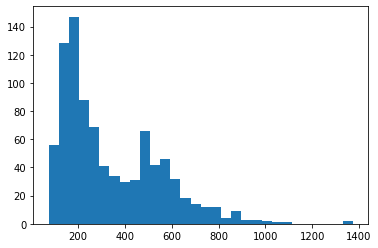

In [223]:
plt.hist(df.wordcount, density=False, bins=30)

(array([337., 273., 109.,  62.,  28.,  17.,   9.,   4.,   5.,   5.,   2.,
          1.,   0.,   2.,   4.,   2.,   1.,   1.,   2.,   2.,   4.,   1.,
          1.,   2.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([  1. ,   7.6,  14.2,  20.8,  27.4,  34. ,  40.6,  47.2,  53.8,
         60.4,  67. ,  73.6,  80.2,  86.8,  93.4, 100. , 106.6, 113.2,
        119.8, 126.4, 133. , 139.6, 146.2, 152.8, 159.4, 166. , 172.6,
        179.2, 185.8, 192.4, 199. ]),
 <a list of 30 Patch objects>)

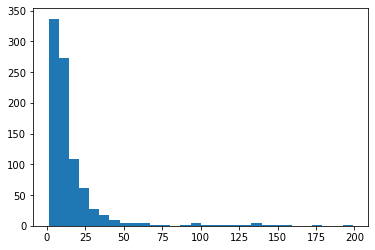

In [224]:
#plt.hist(df.pageviews, density=False, bins=30)
plt.hist(df[df.pageviews <200].pageviews, density=False, bins=30)

# man sieht: die allermeisten Artikel haben 0-50 pageviews, es gibt eber riesige Ausreißer nach oben, wie damit umgehen?

(array([172., 125.,  95.,  68.,  64.,  44.,  39.,  34.,  28.,  21.,  18.,
         18.,   6.,  13.,  14.,  14.,  15.,  12.,   3.,   4.,   6.,   4.,
          6.,   3.,   5.,   6.,   1.,   2.,   3.,   3.]),
 array([   0.        ,  132.26666667,  264.53333333,  396.8       ,
         529.06666667,  661.33333333,  793.6       ,  925.86666667,
        1058.13333333, 1190.4       , 1322.66666667, 1454.93333333,
        1587.2       , 1719.46666667, 1851.73333333, 1984.        ,
        2116.26666667, 2248.53333333, 2380.8       , 2513.06666667,
        2645.33333333, 2777.6       , 2909.86666667, 3042.13333333,
        3174.4       , 3306.66666667, 3438.93333333, 3571.2       ,
        3703.46666667, 3835.73333333, 3968.        ]),
 <a list of 30 Patch objects>)

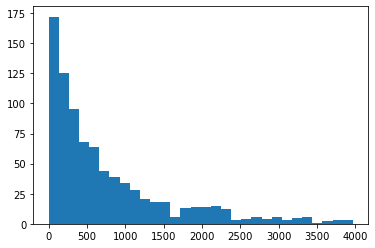

In [225]:
plt.hist(df[df.timeOnPage <4000].timeOnPage, density=False, bins=30)

(array([651., 121.,  30.,  20.,  10.,   9.,  11.,   2.,   4.,   2.,   3.,
          2.,   1.,   1.,   2.,   1.,   2.,   0.,   2.,   0.,   1.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([  0. ,   4.6,   9.2,  13.8,  18.4,  23. ,  27.6,  32.2,  36.8,
         41.4,  46. ,  50.6,  55.2,  59.8,  64.4,  69. ,  73.6,  78.2,
         82.8,  87.4,  92. ,  96.6, 101.2, 105.8, 110.4, 115. , 119.6,
        124.2, 128.8, 133.4, 138. ]),
 <a list of 30 Patch objects>)

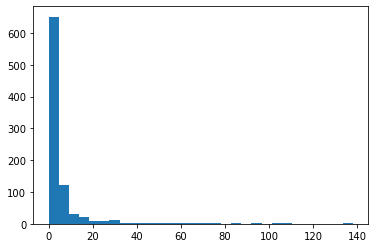

In [226]:
plt.hist(df[df.entrances <150].entrances, density=False, bins=30)

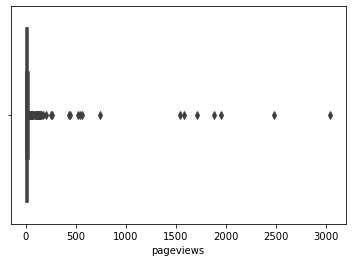

In [227]:
import seaborn as sns
sns.boxplot(x=df.pageviews)

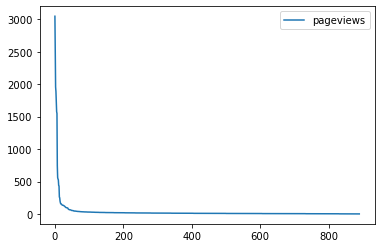

In [228]:
# sorted to see it better
fig, ax = plt.subplots()
#plt.plot(df.sort_values(by=['timeOnPage'], ascending = False).timeOnPage.to_numpy(), label = 'timeOnPage')
plt.plot(df.sort_values(by=['pageviews'], ascending = False).pageviews.to_numpy(), label = 'pageviews')
ax.legend()